In [1]:
# compute cluster energy resolution
import os
import glob
import uproot
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import helper functions
from root_data_loader import load_root_file_chunked, validate_cluster_counts, flatten_to_dataframe

# ============================================================================
# Selections
# ============================================================================
E_MIN = 0.30  # Minimum true energy for clusters to be considered
Eta_MAX = 2.5  # Maximum absolute eta for clusters

# ============================================================================
# Load and prepare data (with chunking)
# ============================================================================

# Configuration
file_pattern = "/mnt/nvme0n1p4/HEP/Work/Project-W-Z/MotorHead/quicktree2histo/plot-recoil/root-files/list_jz02PU_H.root"
tree_name = "IsolatedJet_tree"
branches = ["clus_depE", "clus_rawE", "clus_calE", "clus_altE", "clus_rawEta"]
n_events = None # Process all events
chunk_size = 10000

# Branch mapping
branch_mapping = {
    "clus_depE": "clus_depE",
    "clus_rawE": "clus_rawE",
    "clus_calE": "clus_calE",
    "clus_altE": "clus_altE",
    "clus_rawEta": "clus_rawEta"
}

# Process all chunks and concatenate
all_dfs = []
for chunk_arr in load_root_file_chunked(file_pattern, tree_name, branches, 
                                        chunk_size=chunk_size, n_events=n_events):
    # Validate cluster counts
    validate_cluster_counts(chunk_arr, branches[:-1]) # Exclude 'npv' from validation
    
    # Flatten to DataFrame (cluster branches only)
    cluster_mapping = {k: v for k, v in branch_mapping.items() if k in chunk_arr.fields}
    df_chunk = flatten_to_dataframe(chunk_arr, cluster_mapping)
    
    # Filter and add response columns
    mask_valid = np.isfinite(df_chunk["clus_depE"]) & (df_chunk["clus_depE"] > E_MIN) & (np.abs(df_chunk["clus_rawEta"]) < Eta_MAX)
    df_chunk = df_chunk.loc[mask_valid].reset_index(drop=True)
    df_chunk["response_em"] = df_chunk["clus_rawE"] / df_chunk["clus_depE"]
    df_chunk["response_lc"] = df_chunk["clus_calE"] / df_chunk["clus_depE"]
    df_chunk["response_ml"] = df_chunk["clus_altE"] / df_chunk["clus_depE"]
    
    all_dfs.append(df_chunk)

df = pd.concat(all_dfs, ignore_index=True)
print(f"DataFrame shape: {df.shape}")

Loading file: /mnt/nvme0n1p4/HEP/Work/Project-W-Z/MotorHead/quicktree2histo/plot-recoil/root-files/list_jz02PU_H.root
Total events available: 17370
Reading 17370 events in chunks of 10000
  Loaded events 0-10000
✓ All branches have consistent per-event counts
Flattened to 4718554 clusters
  Loaded events 10000-17370
✓ All branches have consistent per-event counts
Flattened to 3488436 clusters
DataFrame shape: (1236852, 8)


In [2]:
def relative_resolution_68(x):
    if len(x) == 0:
        return 0
    median = np.median(x)
    q16 = np.percentile(x, 16)
    q84 = np.percentile(x, 84)
    return (q84 - q16) / (2 * median)

def median_response(x):
    if len(x) == 0:
        return 0
    return np.median(x)

In [3]:
bin_edges = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
             1200, 1400, 1600, 1800, 2000, 2500, 3000, 4000, 5000,
             6000, 8000, 10000, 20000, 50000, 100000]

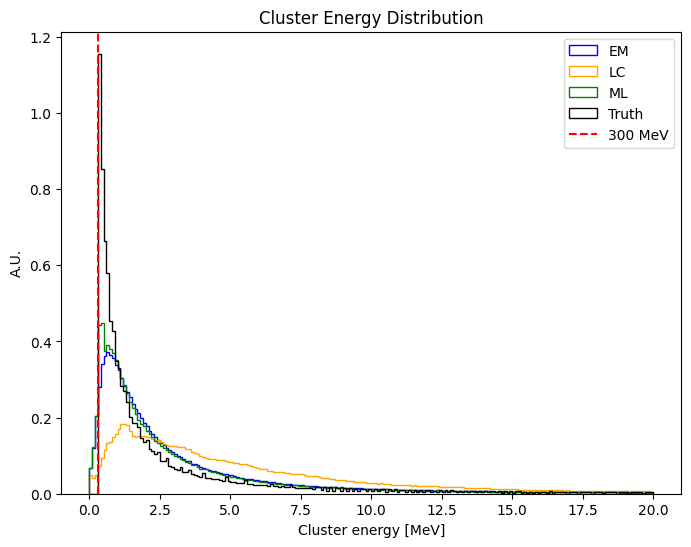

In [4]:
# plot histogram of cluster energy at different scales

min_energy = 0
max_energy = 20
n_bins = 200


plt.figure(figsize=(8,6))
plt.hist(df["clus_rawE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='EM', color='blue', density=True)
plt.hist(df["clus_calE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='LC', color='orange', density=True)
plt.hist(df["clus_altE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='ML', color='green', density=True)
plt.hist(df["clus_depE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='Truth', color='black', density=True)
plt.axvline(x=0.300, color='r', linestyle='--', label='300 MeV')
#plt.yscale('log')
plt.xlabel('Cluster energy [MeV]')
plt.ylabel('A.U.')
plt.title('Cluster Energy Distribution')
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
#plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_distribution.png")
# make a line at 300 MeV
plt.show()

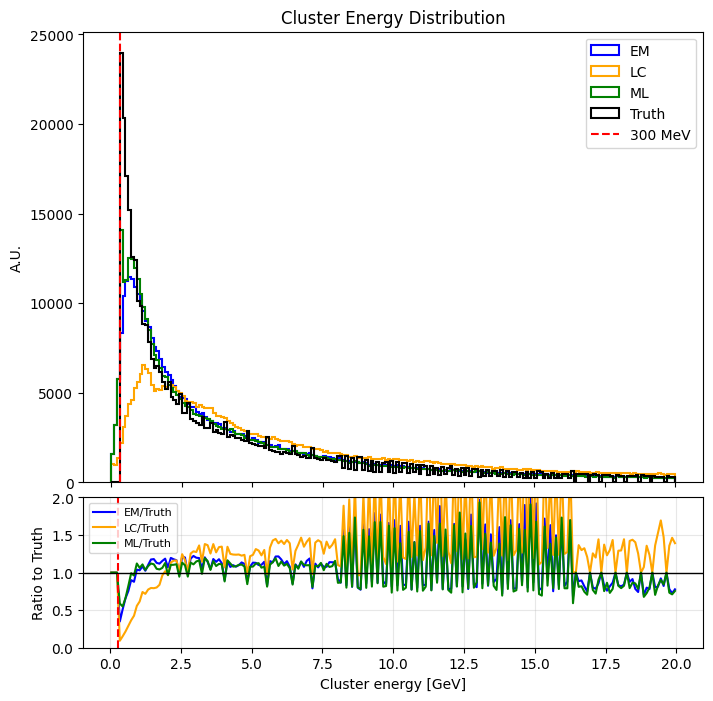

In [ ]:
# plot histogram of cluster energy at different scales with ratio plot

min_energy = 0
max_energy = 20
n_bins = 200

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), 
                                gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

# Main plot
hist_em, bins, _ = ax1.hist(df["clus_rawE"], bins=n_bins, range=(min_energy, max_energy), 
                             histtype='step', label='EM', color='blue', linewidth=1.5)
hist_lc, _, _ = ax1.hist(df["clus_calE"], bins=n_bins, range=(min_energy, max_energy), 
                          histtype='step', label='LC', color='orange', linewidth=1.5)
hist_ml, _, _ = ax1.hist(df["clus_altE"], bins=n_bins, range=(min_energy, max_energy), 
                          histtype='step', label='ML', color='green', linewidth=1.5)
hist_truth, _, _ = ax1.hist(df["clus_depE"], bins=n_bins, range=(min_energy, max_energy), 
                             histtype='step', label='Truth', color='black', linewidth=1.5)

ax1.axvline(x=0.300, color='r', linestyle='--', label='300 MeV')
ax1.set_ylabel('A.U.')
ax1.set_title('Cluster Energy Distribution')
ax1.legend()
ax1.tick_params(axis='x', labelbottom=False)

# Ratio plot
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate ratios (avoid division by zero)
mask_nonzero = hist_truth > 0
ratio_em = np.ones_like(hist_em)
ratio_lc = np.ones_like(hist_lc)
ratio_ml = np.ones_like(hist_ml)

ratio_em[mask_nonzero] = hist_em[mask_nonzero] / hist_truth[mask_nonzero]
ratio_lc[mask_nonzero] = hist_lc[mask_nonzero] / hist_truth[mask_nonzero]
ratio_ml[mask_nonzero] = hist_ml[mask_nonzero] / hist_truth[mask_nonzero]

ax2.plot(bin_centers, ratio_em, color='blue', linewidth=1.5, label='EM/Truth')
ax2.plot(bin_centers, ratio_lc, color='orange', linewidth=1.5, label='LC/Truth')
ax2.plot(bin_centers, ratio_ml, color='green', linewidth=1.5, label='ML/Truth')
ax2.axhline(y=1, color='black', linestyle='-', linewidth=1)
ax2.axvline(x=0.300, color='r', linestyle='--')

ax2.set_xlabel('Cluster energy [GeV]')
ax2.set_ylabel('Ratio to Truth')
ax2.set_ylim(0.0, 2.0)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=8)

plt.savefig("cluster_energy_distribution_with_ratio.png", dpi=150, bbox_inches='tight')
plt.show()